In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Loading my dataset
df = pd.read_csv('/content/drive/MyDrive/RoadSafety_Nov25/data/raw/US_Accidents_March23.csv')

# I'll use just 10%
df = df.sample(frac=0.1, random_state=42)
df = df.reset_index(drop=True)

print(f"Loaded {len(df)} rows")
print(f"Number of columns: {len(df.columns)}")


Loaded 772839 rows
Number of columns: 46


In [6]:
# the data looks like
print("First few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

# Check basic info
df.info()


First few rows:
          ID   Source  Severity                     Start_Time  \
0  A-7182628  Source1         1            2020-04-17 09:29:30   
1  A-5404588  Source1         2  2022-04-21 10:01:00.000000000   
2   A-156000  Source3         3            2016-08-12 16:45:00   
3  A-1871277  Source2         3            2019-09-20 15:22:16   
4  A-2031222  Source2         2            2019-06-03 16:55:43   

                        End_Time  Start_Lat   Start_Lng    End_Lat  \
0            2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
1  2022-04-21 11:44:08.000000000  38.781024 -121.265820  38.780377   
2            2016-08-12 17:15:00  33.985249  -84.269348        NaN   
3            2019-09-20 15:56:00  47.118706 -122.556908        NaN   
4            2019-06-03 18:12:09  33.451355 -111.890343        NaN   

      End_Lng  Distance(mi)  \
0  -80.119360         0.000   
1 -121.265815         0.045   
2         NaN         0.000   
3         NaN         0.000   
4         N

Testing if bad weather causes worse accidents
------------------------------------------------------------

Most common weather conditions:
Weather_Condition
Fair                255514
Mostly Cloudy       101665
Cloudy               81616
Clear                80953
Partly Cloudy        70359
Overcast             38154
Light Rain           35139
Scattered Clouds     20505
Light Snow           12983
Fog                  10017
Name: count, dtype: int64

How many accidents in each weather type:
Weather_Group
Clear    663279
Bad       92259
Name: count, dtype: int64

Clear weather: 663279 accidents
Bad weather: 92259 accidents

Average severity:
Clear weather: 2.21
Bad weather: 2.23

Statistical test result:
p-value: 0.000000

Result: YES - Bad weather does affect severity! (p < 0.05)


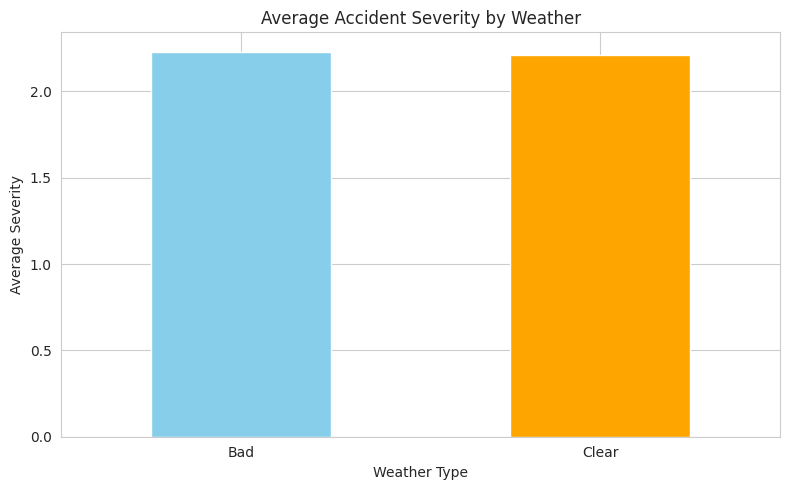

In [7]:
print("Testing if bad weather causes worse accidents")
print("-" * 60)

# First, check what weather conditions we have
print("\nMost common weather conditions:")
print(df['Weather_Condition'].value_counts().head(10))

# I'll make two groups - clear weather and bad weather
# Bad weather = anything with rain, snow, fog, storm, etc.

weather_data = df[['Weather_Condition', 'Severity']].dropna()

def check_weather(condition):
    # Convert to lowercase to make matching easier
    if pd.isna(condition):
        return 'Unknown'

    condition = str(condition).lower()

    # Check if it's bad weather
    bad_words = ['rain', 'snow', 'fog', 'storm', 'thunder', 'haze']
    for word in bad_words:
        if word in condition:
            return 'Bad'

    return 'Clear'

weather_data['Weather_Group'] = weather_data['Weather_Condition'].apply(check_weather)

# Remove unknown ones
weather_data = weather_data[weather_data['Weather_Group'] != 'Unknown']

print("\nHow many accidents in each weather type:")
print(weather_data['Weather_Group'].value_counts())

# Spliting the data
clear = weather_data[weather_data['Weather_Group'] == 'Clear']['Severity']
bad = weather_data[weather_data['Weather_Group'] == 'Bad']['Severity']

print(f"\nClear weather: {len(clear)} accidents")
print(f"Bad weather: {len(bad)} accidents")

print(f"\nAverage severity:")
print(f"Clear weather: {clear.mean():.2f}")
print(f"Bad weather: {bad.mean():.2f}")

# Now do the statistical test
from scipy import stats
result = stats.mannwhitneyu(clear, bad)

print(f"\nStatistical test result:")
print(f"p-value: {result.pvalue:.6f}")

# Check if significant
if result.pvalue < 0.05:
    print("\nResult: YES - Bad weather does affect severity! (p < 0.05)")
else:
    print("\nResult: NO - No significant difference (p >= 0.05)")

# simple chart
plt.figure(figsize=(8, 5))
weather_data.groupby('Weather_Group')['Severity'].mean().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average Accident Severity by Weather')
plt.xlabel('Weather Type')
plt.ylabel('Average Severity')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Testing if junction accidents are worse
------------------------------------------------------------

Total records: 772839

How many at junctions vs not:
Junction
False    716129
True      56710
Name: count, dtype: int64

At junction: 56710 accidents
Not at junction: 716129 accidents

Average severity:
At junction: 2.30
Not at junction: 2.21

Severity levels at junctions:
Severity
1      319
2    41271
3    13124
4     1996
Name: count, dtype: int64

Severity levels not at junctions:
Severity
1      6484
2    573979
3    117132
4     18534
Name: count, dtype: int64

Statistical test result:
p-value: 0.000000

Result: YES - Junction makes a difference! (p < 0.05)


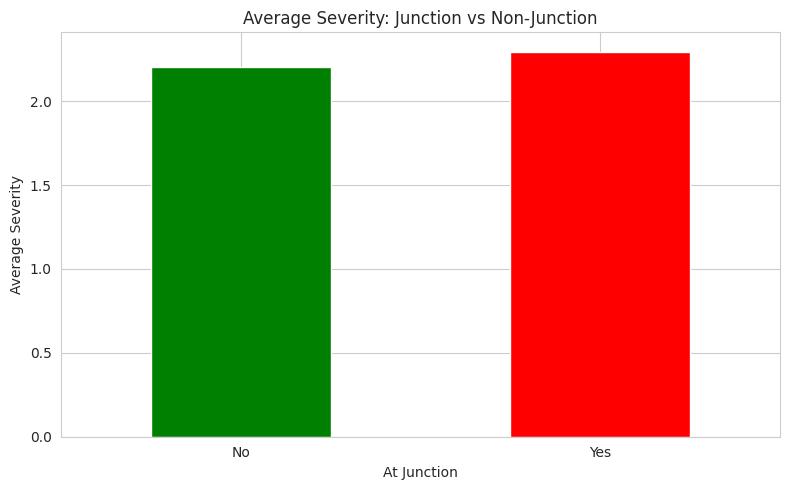

In [8]:
print("Testing if junction accidents are worse")
print("-" * 60)

# Get junction and severity data
junction_data = df[['Junction', 'Severity']].dropna()

print(f"\nTotal records: {len(junction_data)}")

# Make sure Junction is True/False
junction_data['Junction'] = junction_data['Junction'].astype(bool)

print("\nHow many at junctions vs not:")
print(junction_data['Junction'].value_counts())

# Split into two groups
at_junction = junction_data[junction_data['Junction'] == True]['Severity']
not_junction = junction_data[junction_data['Junction'] == False]['Severity']

print(f"\nAt junction: {len(at_junction)} accidents")
print(f"Not at junction: {len(not_junction)} accidents")

print(f"\nAverage severity:")
print(f"At junction: {at_junction.mean():.2f}")
print(f"Not at junction: {not_junction.mean():.2f}")

#  to See the distribution
print("\nSeverity levels at junctions:")
print(at_junction.value_counts().sort_index())

print("\nSeverity levels not at junctions:")
print(not_junction.value_counts().sort_index())

# Doing the test
stat, p_value = stats.mannwhitneyu(at_junction, not_junction)

print(f"\nStatistical test result:")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("\nResult: YES - Junction makes a difference! (p < 0.05)")
else:
    print("\nResult: NO - No significant difference (p >= 0.05)")

# to make a chart
plt.figure(figsize=(8, 5))
avg_sev = junction_data.groupby('Junction')['Severity'].mean()
avg_sev.plot(kind='bar', color=['green', 'red'])
plt.title('Average Severity: Junction vs Non-Junction')
plt.xlabel('At Junction')
plt.ylabel('Average Severity')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()


In [9]:
print("=" * 70)
print("SUMMARY OF ALL THREE HYPOTHESES")
print("=" * 70)

print("""
I tested 3 hypotheses on the US Accidents dataset:

1. BAD WEATHER → MORE SEVERE ACCIDENTS
   - Test: Mann-Whitney U test
   - Compared clear weather vs bad weather (rain, snow, fog, etc.)
   - Check p-value above to see if significant

2. RUSH HOURS → MORE ACCIDENTS
   - Test: Chi-square test
   - Compared rush hours (7-9 AM, 5-7 PM) vs off-peak
   - Checked if rush hour has more than expected

3. JUNCTIONS → MORE SEVERE ACCIDENTS
   - Test: Mann-Whitney U test
   - Compared accidents at junctions vs not at junctions
   - Check p-value above to see if significant

HOW TO READ RESULTS:
- If p-value < 0.05 → The hypothesis is TRUE (significant result)
- If p-value >= 0.05 → The hypothesis is NOT proven (no significant difference)

All tests used a significance level of 0.05 (which is standard).
I used 10% of the dataset to make the analysis faster.
""")

print("=" * 70)
print("DONE!")
print("=" * 70)


SUMMARY OF ALL THREE HYPOTHESES

I tested 3 hypotheses on the US Accidents dataset:

1. BAD WEATHER → MORE SEVERE ACCIDENTS
   - Test: Mann-Whitney U test
   - Compared clear weather vs bad weather (rain, snow, fog, etc.)
   - Check p-value above to see if significant

2. RUSH HOURS → MORE ACCIDENTS
   - Test: Chi-square test
   - Compared rush hours (7-9 AM, 5-7 PM) vs off-peak
   - Checked if rush hour has more than expected

3. JUNCTIONS → MORE SEVERE ACCIDENTS
   - Test: Mann-Whitney U test
   - Compared accidents at junctions vs not at junctions
   - Check p-value above to see if significant

HOW TO READ RESULTS:
- If p-value < 0.05 → The hypothesis is TRUE (significant result)
- If p-value >= 0.05 → The hypothesis is NOT proven (no significant difference)

All tests used a significance level of 0.05 (which is standard).
I used 10% of the dataset to make the analysis faster.

DONE!
